# 1 Introduction
First, we have to activate the environment. The first run may take a while as external libraries will be downloaded and compiled.

In [1]:
Pkg.activate(".")

  Activating project at `~/code/OpenScience21.jl`


In [2]:
using QuantumCircuits
using QuantumCircuits.QML
using QuantumCircuits.QML.Optimization
using QuantumCircuits.QCircuits.Circuit
using QuantumCircuits.QCircuits.ComplexGates
using QuantumCircuits.Execute

# 2 ZZ, XX, and YY gates
Now we have to create ZZ, XX, and YY gates for use in simulation.

In [3]:
# This code com from using OpenScience21.Simulation.Gates module.
function ZZ(qc, q0, q1, t, usePulse=false)
    if usePulse
        qc.h(q1)
        qc.rzx(q0, q1, t)
        qc.x(q0)
        qc.rzx(q0, q1, -t)
        qc.x(q0)
        qc.h(q1)
    else
        qc.cx(q0, q1)
        qc.rz(q1, 2*t)
        qc.cx(q0, q1)
    end
end

function YY(qc, q0, q1, t, usePulse=false)
    if usePulse
        qc.sdg([q0, q1])
        qc.h(q0)
        qc.rzx(q0, q1, t)
        qc.x(q0)
        qc.rzx(q0, q1, -t)
        qc.x(q0)
        qc.h(q0)
        qc.s([q0, q1])
    else
        qc.rx([q0, q1], π/2)
        qc.cx(q0, q1)
        qc.rz(q1, 2*t)
        qc.cx(q0, q1)
        qc.rx([q0, q1], -π/2)
    end
end

function XX(qc, q0, q1, t, usePulse=false)
    if usePulse
        qc.h(q0)
        qc.rzx(q0, q1, t)
        qc.x(q0)
        qc.rzx(q0, q1, -t)
        qc.x(q0)
        qc.h(q0)
    else
        qc.ry([q0, q1], π/2)
        qc.cx(q0, q1)
        qc.rz(q1, 2*t)
        qc.cx(q0, q1)
        qc.ry([q0, q1], -π/2)
    end
end


XX (generic function with 2 methods)

# 3 U4 - Cartan's KAK decomposition
Any 2 qubits unitary can be decomposed used 3 cx gate (see the paper _"Minimal Universal Two-qubit Quantum Circuits"_ https://arxiv.org/abs/quant-ph/0308033). In QuantumCircuits library we have defined the U4 gate.

In [4]:
qc = QCircuit(2)
# Create u4 gate with random parameter
qc.u4(0, 1) 

# Decompose circuit to use base gates
qc2 = decompose(qc)
qc2

      ┌──────────────────────────┐┌───┐┌────────────┐                   ┌───┐»
q0_0: ┤ U3(2.2832,4.3098,1.6032) ├┤ X ├┤ Rz(3.6536) ├──■────────────────┤ X ├»
      ├─────────────────────────┬┘└─┬─┘├────────────┤┌─┴─┐┌────────────┐└─┬─┘»
q0_1: ┤ U3(4.263,1.3415,2.3539) ├───■──┤ Ry(5.2857) ├┤ X ├┤ Ry(4.1467) ├──■──»
      └─────────────────────────┘      └────────────┘└───┘└────────────┘     »
c0: 2/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«      ┌────────────────────────────┐
«q0_0: ┤ U3(3.4384,0.79627,0.14553) ├
«      └┬──────────────────────────┬┘
«q0_1: ─┤ U3(4.9937,3.1561,5.6151) ├─
«       └──────────────────────────┘ 
«c0: 2/══════════════════════════════
«                                    

Let us assume that we would like to find parameters of the U4 gate implementing exactly ZZ, YY, and XX gate combinations for a given time $t$.

In [5]:
t = π/2

qc = QCircuit(2)
ZZ(qc, 0, 1, t)
YY(qc, 0, 1, t)
XX(qc, 0, 1, t)
expmat = tomatrix(qc)
qc

                         ┌─────────┐                   ┌──────────┐┌─────────┐»
q1_0: ──■─────────────■──┤ Rx(π/2) ├──■─────────────■──┤ Rx(-π/2) ├┤ Ry(π/2) ├»
      ┌─┴─┐┌───────┐┌─┴─┐├─────────┤┌─┴─┐┌───────┐┌─┴─┐├──────────┤├─────────┤»
q1_1: ┤ X ├┤ Rz(π) ├┤ X ├┤ Rx(π/2) ├┤ X ├┤ Rz(π) ├┤ X ├┤ Rx(-π/2) ├┤ Ry(π/2) ├»
      └───┘└───────┘└───┘└─────────┘└───┘└───────┘└───┘└──────────┘└─────────┘»
c1: 2/════════════════════════════════════════════════════════════════════════»
                                                                              »
«                         ┌──────────┐
«q1_0: ──■─────────────■──┤ Ry(-π/2) ├
«      ┌─┴─┐┌───────┐┌─┴─┐├──────────┤
«q1_1: ┤ X ├┤ Rz(π) ├┤ X ├┤ Ry(-π/2) ├
«      └───┘└───────┘└───┘└──────────┘
«c1: 2/═══════════════════════════════
«                                     

We have to choose the ansact, in our case this will be a U4 gate and in that case, we are sure that we always can find the correct parameters.

In [6]:
    qr = QuantumRegister(2)
    qc = QCircuit(qr)
    qc.u4(qr[0], qr[1])

    params = getRandParameters(qc)
    setparameters!(qc, params)
    qc = decompose(qc)

      ┌───────────────────────────┐┌───┐┌────────────┐                   ┌───┐»
q2_0: ┤ U3(1.7624,0.77116,3.9005) ├┤ X ├┤ Rz(5.2775) ├──■────────────────┤ X ├»
      └┬──────────────────────────┤└─┬─┘├────────────┤┌─┴─┐┌────────────┐└─┬─┘»
q2_1: ─┤ U3(5.0677,5.7902,6.2463) ├──■──┤ Ry(4.4635) ├┤ X ├┤ Ry(2.5877) ├──■──»
       └──────────────────────────┘     └────────────┘└───┘└────────────┘     »
«      ┌──────────────────────────┐
«q2_0: ┤ U3(0.89282,1.8969,3.728) ├
«      ├──────────────────────────┤
«q2_1: ┤ U3(4.2926,2.4936,2.6366) ├
«      └──────────────────────────┘

Now we can find the parameter of our ansact that perfectly fit our expected unitary matrix.

In [7]:
params, _, err, _  = findparam(expmat, qc, debug=false, trystandard=false)
err

8.988143676440324e-8

In [8]:
qc

      ┌──────────────────────────┐┌───┐┌──────────┐                ┌───┐»
q3_0: ┤ U3(1.4791,0.48683,4.394) ├┤ X ├┤ Rz(3π/2) ├──■─────────────┤ X ├»
      └─┬─────────────────────┬──┘└─┬─┘├──────────┤┌─┴─┐┌─────────┐└─┬─┘»
q3_1: ──┤ U3(π,5.7747,5.1031) ├─────■──┤ Ry(3π/2) ├┤ X ├┤ Ry(π/2) ├──■──»
        └─────────────────────┘        └──────────┘└───┘└─────────┘     »
«      ┌───────────────────────────┐
«q3_0: ┤ U3(-1.4791,1.8894,4.2257) ├
«      └──┬─────────────────────┬──┘
«q3_1: ───┤ U3(π,1.9652,2.8646) ├───
«         └─────────────────────┘   

A description of the optimization method used is available in the notebook [06_Optimization](06_Optimization.ipynb).

# 4  The effective implementation of the Trotter step

Assume that we would like to implement the Trotter step using the second-order Trotter formula (see _"Quantum computers as universal quantum simulators: state-of-art and perspectives"_ https://arxiv.org/abs/1907.03505), we can do this using the circuit in below.

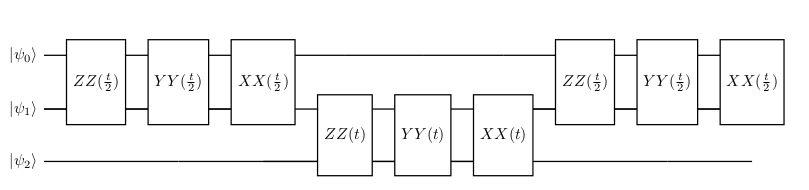

Using Cartan's KAK decomposition we can rewrite this circuit and replace ZZ, YY, and XX by singe U4 gate as in Figure below.

<img src="images/Trotter_u4.jpg" width="400" height="300">

Assume that we would like to implement the 2 Trotter step using the second-order Trotter formula. Using Cartan's KAK decomposition each step contains 3 U4 gates. But merging the two $U4$ gates on qubits 0 and 1, the two steps of the Trotter formula using KAK decomposition look like in the Figure below. It's worth noting that these two steps of Trotter utilize only 15 CNOT gates (3 CNOT for each of the U4 gates).

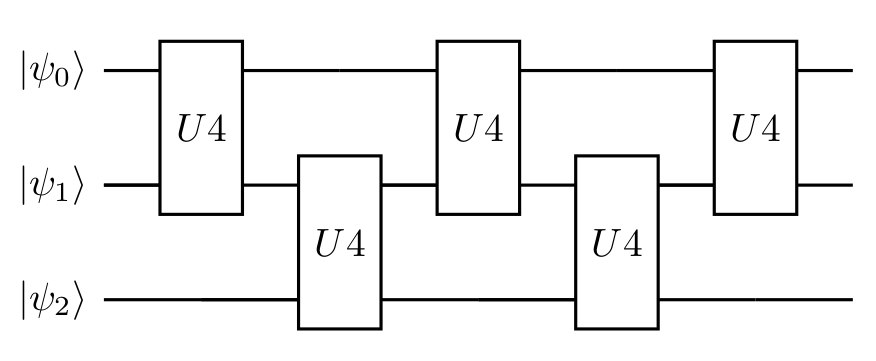

Effective implementation of the two steps is important because this is how much we use in the model training process (see notebook [05_trening](05_trening.ipynb)). However, a similar method of connecting two U4 gates can be used for any number of steps. 

# 5 Simulation
First we create helper function which find the parameter for U4 for ZZ, YY, and XX gates and ZZ, YY, XX, ZZ, YY and, XX and Trotter step.

In [9]:
# This code com from using OpenScience21.Simulation.Gates module.
function findU4paramsZZYYXX(t; debug=false)
    qc = QCircuit(2)
    ZZ(qc, 0, 1, t)
    YY(qc, 0, 1, t)
    XX(qc, 0, 1, t)
    expmat = tomatrix(qc)


    qr = QuantumRegister(2)
    qc = QCircuit(qr)
    qc.u4(qr[0], qr[1])

    params = getRandParameters(qc)
    setparameters!(qc, params)
    qc = decompose(qc)

    params, _, err, _  = findparam(expmat, qc, debug=debug, trystandard=false)

    @assert err < 1e-5 "The error of U gate should be small but it is $err."

    return params
end

function findU4paramsZZYYXXx2(t; debug=false)
    qc = QCircuit(2)
    ZZ(qc, 0, 1, t)
    YY(qc, 0, 1, t)
    XX(qc, 0, 1, t)
    ZZ(qc, 0, 1, t)
    YY(qc, 0, 1, t)
    XX(qc, 0, 1, t)
    expmat = tomatrix(qc)


    qr = QuantumRegister(2)
    qc = QCircuit(qr)
    qc.u4(qr[0], qr[1])

    params = getRandParameters(qc)
    setparameters!(qc, params)
    qc = decompose(qc)

    params, _, err, _  = findparam(expmat, qc, debug=debug, trystandard=false)
    @assert err < 1e-5 "The error of U gate should be small but it is $err."

    return params
end

function trotter2U4(qc, qubits, t, isFirst, isLast, params, params2, params3)
    if isFirst
        for i in 1:(length(qubits)-2)
            qc.u4(qubits[i], qubits[i+1], params2)
        end
    end

    i = length(qubits) - 1
    qc.u4(qubits[i], qubits[i+1], params)

    if isLast
        for i in 1:(length(qubits)-2)
            qc.u4(qubits[i], qubits[i+1], params2)
        end
    else
        for i in 1:(length(qubits)-2)
            qc.u4(qubits[i], qubits[i+1], params3)
        end
    end
end

trotter2U4 (generic function with 1 method)

Next function generate circuit of the simulation algorithm for given Trotter steps number.

In [10]:
function generate_circuit(trotter_steps, run_step, t=π, params=nothing, params2=nothing, params3=nothing; init=false, debug=false)
    qr = QuantumRegister(7, "q")
    qc = QCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    if init
        qc.x([3, 5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    end

    if params == nothing
        params = findU4paramsZZYYXX(t / trotter_steps, debug=debug)
        params2 = findU4paramsZZYYXX(t / (2 * trotter_steps), debug=debug)
        params3 = findU4paramsZZYYXXx2(t / (2 * trotter_steps), debug=debug)
    end

    qubits = [qr[1], qr[3], qr[5]]
    for s in 1:run_step
        isFirst = s == 1
        isLast = s == run_step

        trotter2U4(qc, qubits, t / trotter_steps, isFirst, isLast, params, params2, params3)
    end

    qc = decompose(qc)
    return qc, params, params2, params3
end

generate_circuit (generic function with 5 methods)

Now we can generate the circuit.

In [11]:
t = π
trotter_steps = 10
qc_full, _, _, _ = generate_circuit(trotter_steps, trotter_steps, t, init=true)

# Add measurment
cr = ClassicalRegister(3)
setClassicalRegister!(qc_full, cr)
qc_full.measure([1, 3, 5], [0, 1, 2])
qc_full

                                                                               »
 q_0: ─────────────────────────────────────────────────────────────────────────»
      ┌────────────────────────┐                              ┌───┐┌──────────┐»
 q_1: ┤ U3(2π,5.3676,0.032489) ├──────────────────────────────┤ X ├┤ Rz(7π/5) ├»
      └────────────────────────┘                              └─┬─┘└──────────┘»
 q_2: ──────────────────────────────────────────────────────────┼──────────────»
                ┌───┐             ┌────────────────────────┐    │  ┌──────────┐»
 q_3: ──────────┤ X ├─────────────┤ U3(-π,0.70057,-1.7539) ├────■──┤ Ry(7π/5) ├»
                └───┘             └────────────────────────┘       └──────────┘»
 q_4: ─────────────────────────────────────────────────────────────────────────»
                ┌───┐           ┌────────────────────────────┐                 »
 q_5: ──────────┤ X ├───────────┤ U3(3.1416,3.5375,-0.46269) ├─────────────────»
                └───┘       

Next helper function is used to compare the simulation results with  exact values.

In [12]:
using QuantumCircuits.QCircuits.Math
using QuantumCircuits.QCircuits.Gates: Xmatrix, Ymatrix, Zmatrix

XXs = kron(kron(eye(2), Xmatrix), Xmatrix) + kron(kron(Xmatrix, Xmatrix), eye(2))
YYs = kron(kron(eye(2), Ymatrix), Ymatrix) + kron(kron(Ymatrix, Ymatrix), eye(2))
ZZs = kron(kron(eye(2), Zmatrix), Zmatrix) + kron(kron(Zmatrix, Zmatrix), eye(2))
Hs = XXs + YYs + ZZs

U_heis3(t) = exp(-im * Hs * t)

const backend = QuantumSimulator()

function check_simulation_err(qc, t)
    sym_full = execute(backend, qc)
    exp_full = U_heis3(t) * ket"110"
    exp_full = abs.(exp_full) .^ 2
    return sum(abs.(sym_full - exp_full))
end

check_simulation_err (generic function with 1 method)

And, now we can check the results.

In [13]:
check_simulation_err(qc_full, t)

0.10278310866155166